<a href="https://colab.research.google.com/github/tikendraw/caption-generator/blob/main/train_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dependencies

import os
import sys
if 'google.colab' in sys.modules:
    os.system('git clone https://github.com/tikendraw/caption-generator.git -q')
    os.chdir('caption-generator')


if not os.path.exists('funcyou'):
	os.system('git clone https://github.com/tikendraw/funcyou -q')

os.system('pip install funcyou/. -q')


import numpy as np
import pandas as pd
import random, math
import tensorflow as tf
import glob
import shutil
from zipfile import ZipFile
import datetime
import sys
from functools import cache
from pathlib import Path
from tqdm import tqdm
import regex as re

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import pad_sequences
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from collections import Counter

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessing
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, TensorBoard
from model import LearningRateDecayCallback, get_model, masked_acc, masked_loss
import regex as re
from preprocessing import preprocess_text, embedding_matrix_creater, mapper
from utils import create_model_checkpoint

from preprocessing import clean_words, clean_df
from config import config

from get_data import download_dataset
from funcyou.dataset import download_kaggle_dataset

94668760/94668760 [==============================] - 0s 0us/step


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
seed_value = 12321
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)


BATCH_SIZE =    config.BATCH_SIZE
IMG_SIZE =      config.IMG_SIZE
CHANNELS =      config.CHANNELS
IMG_SHAPE =     config.IMG_SHAPE
MAX_LEN =       config.MAX_LEN
EPOCHS =        config.EPOCHS
LEARNING_RATE = config.LEARNING_RATE
UNITS =         config.UNITS
raw_caption_file =  config.raw_caption_file
caption_file =  config.caption_file
image_dir =     config.image_dir
glove_path =    config.glove_path
TEST_SIZE =     config.TEST_SIZE
VAL_SIZE=       config.VAL_SIZE
EMBEDDING_DIMENSION =   config.EMBEDDING_DIMENSION 


In [4]:
pathh = '/content/kaggle.json'

In [7]:
if 'google.colab' in sys.module:
    download_dataset(pathh)

Downloading...
kaggle datasets download -d hsankesara/flickr-image-dataset


100B [02:39, 1.60s/B]


Downloaded.
Extracting...
Moving...
Done
Cleaned.


# Reading

In [20]:
df = pd.read_csv(caption_file)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158914 entries, 0 to 158913
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      158914 non-null  int64 
 1   image_name      158914 non-null  object
 2   comment_number  158914 non-null  int64 
 3   comment         158914 non-null  object
 4   word_length     158914 non-null  int64 
 5   image_path      158914 non-null  object
dtypes: int64(3), object(3)
memory usage: 7.3+ MB
None


,Unnamed: 0,image_name,comment_number,comment,word_length,image_path
0,0,1000092795.jpg,0,startseq Two young guys with shaggy hair look ...,17,input/flickr30k/images/1000092795.jpg
1,1,1000092795.jpg,1,startseq Two young White males are outside nea...,11,input/flickr30k/images/1000092795.jpg
2,2,1000092795.jpg,2,startseq Two men in green shirts are standing ...,11,input/flickr30k/images/1000092795.jpg
3,3,1000092795.jpg,3,startseq A man in a blue shirt standing in a g...,11,input/flickr30k/images/1000092795.jpg
4,4,1000092795.jpg,4,startseq Two friends enjoy time together endseq,7,input/flickr30k/images/1000092795.jpg


In [21]:
df = df[df.comment_number == 1]
print(df.shape)

(31783, 6)


# Tokenize

In [22]:



#tokenizer
tokenizer = TextVectorization(standardize=preprocess_text)
tokenizer.adapt(df['comment'])


word_to_id = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)


In [24]:



#GLOVE embedding
glove_api_command = 'kaggle datasets download -d watts2/glove6b50dtxt'
glove_url = 'https://www.kaggle.com/datasets/watts2/glove6b50dtxt'

# if 'google.colab' in sys.modules:

#     download_kaggle_dataset(glove_api_command)
#     os.makedirs('embedding', exist_ok = True)
#     shutil.move('glove6b50dtxt.zip', 'embedding/glove.6B.50d.zip',)


# creating embedding matrix
word_dict = {word: i for i, word in enumerate(tokenizer.get_vocabulary())}

# Creating embedding matrix
embedding_matrix = embedding_matrix_creater(EMBEDDING_DIMENSION, word_index=word_dict)

# # Saving embedding_matrix for further use
# np.save("./embedding/embedding_matrix.npy", embedding_matrix, allow_pickle=True)
# # compressing
# ZipFile("embedding_matrix.zip", mode="w").write(
#     "./embedding/embedding_matrix.npy")


# load image model
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE))

resnet.trainable = False


# Creating dataset
TEST_SIZE = config.TEST_SIZE
VAL_SIZE =  config.VAL_SIZE

train, val = train_test_split(
    df[['image_path', 'comment']],  test_size=VAL_SIZE, random_state=11)
train, test = train_test_split(
    train[['image_path', 'comment']],  test_size=TEST_SIZE, random_state=11)



train_data = tf.data.Dataset.from_tensor_slices((train.image_path, train.comment))
test_data = tf.data.Dataset.from_tensor_slices((test.image_path, test.comment))
val_data = tf.data.Dataset.from_tensor_slices((val.image_path, val.comment))


train_data = train_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_data =   test_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_data =     val_data.map(lambda x,y:mapper(x, y, tokenizer)).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# resnet_output_flattened_shape = 8*8*2048

print("Number of training samples: %d" %
      tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" %
      tf.data.experimental.cardinality(val_data))
print("Number of test samples: %d" %
      tf.data.experimental.cardinality(test_data))

VOCAB_SIZE = tokenizer.vocabulary_size()
print("Vocabulary size: %d" % VOCAB_SIZE)


Number of training samples: 3586
Number of validation samples: 199
Number of test samples: 189
Vocabulary size: 7653
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 50)       382650      ['input_7[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 50, 16),     4288        ['embedding_1[0][0]']            
                                 (None, 16),                                                      
                                 (None, 16)]                              

In [46]:
# model, img_model = get_model(embedding_matrix, VOCAB_SIZE)
# print(model.summary(), img_model.summary())

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
#               loss=masked_loss,
#               metrics=[masked_acc, masked_loss])


# model = tf.keras.models.load_model('/content/drive/MyDrive/cap-gen/2023-05-14 08:04:36.705364-30.tf')


In [47]:
# Example usage
initial_lr = LEARNING_RATE
decay_rate = 0.001
decay_steps = 10

decay_callback = LearningRateDecayCallback(initial_lr, decay_rate, decay_steps)

os.makedirs('log', exist_ok=True)
csv_logger = CSVLogger('./log/training.log')
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

In [48]:
print(initial_lr)

0.01


In [49]:
EPOCHS = 3

print(len(train_data) // EPOCHS, len(val_data) // EPOCHS)

steps_per_epoch = int(0.1*(len(train_data) / EPOCHS))
validation_steps =  int(.2*(len(val_data) / EPOCHS))
print(steps_per_epoch, validation_steps)


1195 66
119 13


In [50]:

history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    callbacks=[
                        # decay_callback,
                        csv_logger, create_model_checkpoint(model_name = 'capgen', save_dir = 'checkpoints', monitor = 'masked_acc')
                                ]
                    )


Epoch 1/3
119/119 [==============================] - ETA: 0s - loss: 20.9651 - masked_acc: 0.0166 - masked_loss: 20.9653

119/119 [==============================] - 323s 3s/step - loss: 20.9651 - masked_acc: 0.0166 - masked_loss: 20.9653 - val_loss: 20.6464 - val_masked_acc: 0.0564 - val_masked_loss: 20.6516
Epoch 2/3
119/119 [==============================] - 285s 2s/step - loss: 20.9426 - masked_acc: 0.0153 - masked_loss: 20.9425 - val_loss: 20.6462 - val_masked_acc: 0.0564 - val_masked_loss: 20.6514
Epoch 3/3
119/119 [==============================] - 323s 3s/step - loss: 20.9382 - masked_acc: 0.0153 - masked_loss: 20.9374 - val_loss: 20.6459 - val_masked_acc: 0.0564 - val_masked_loss: 20.6511


In [37]:
from funcyou.plot import plot_history
import pandas as pd



Error Occured:  name 'pd' is not defined


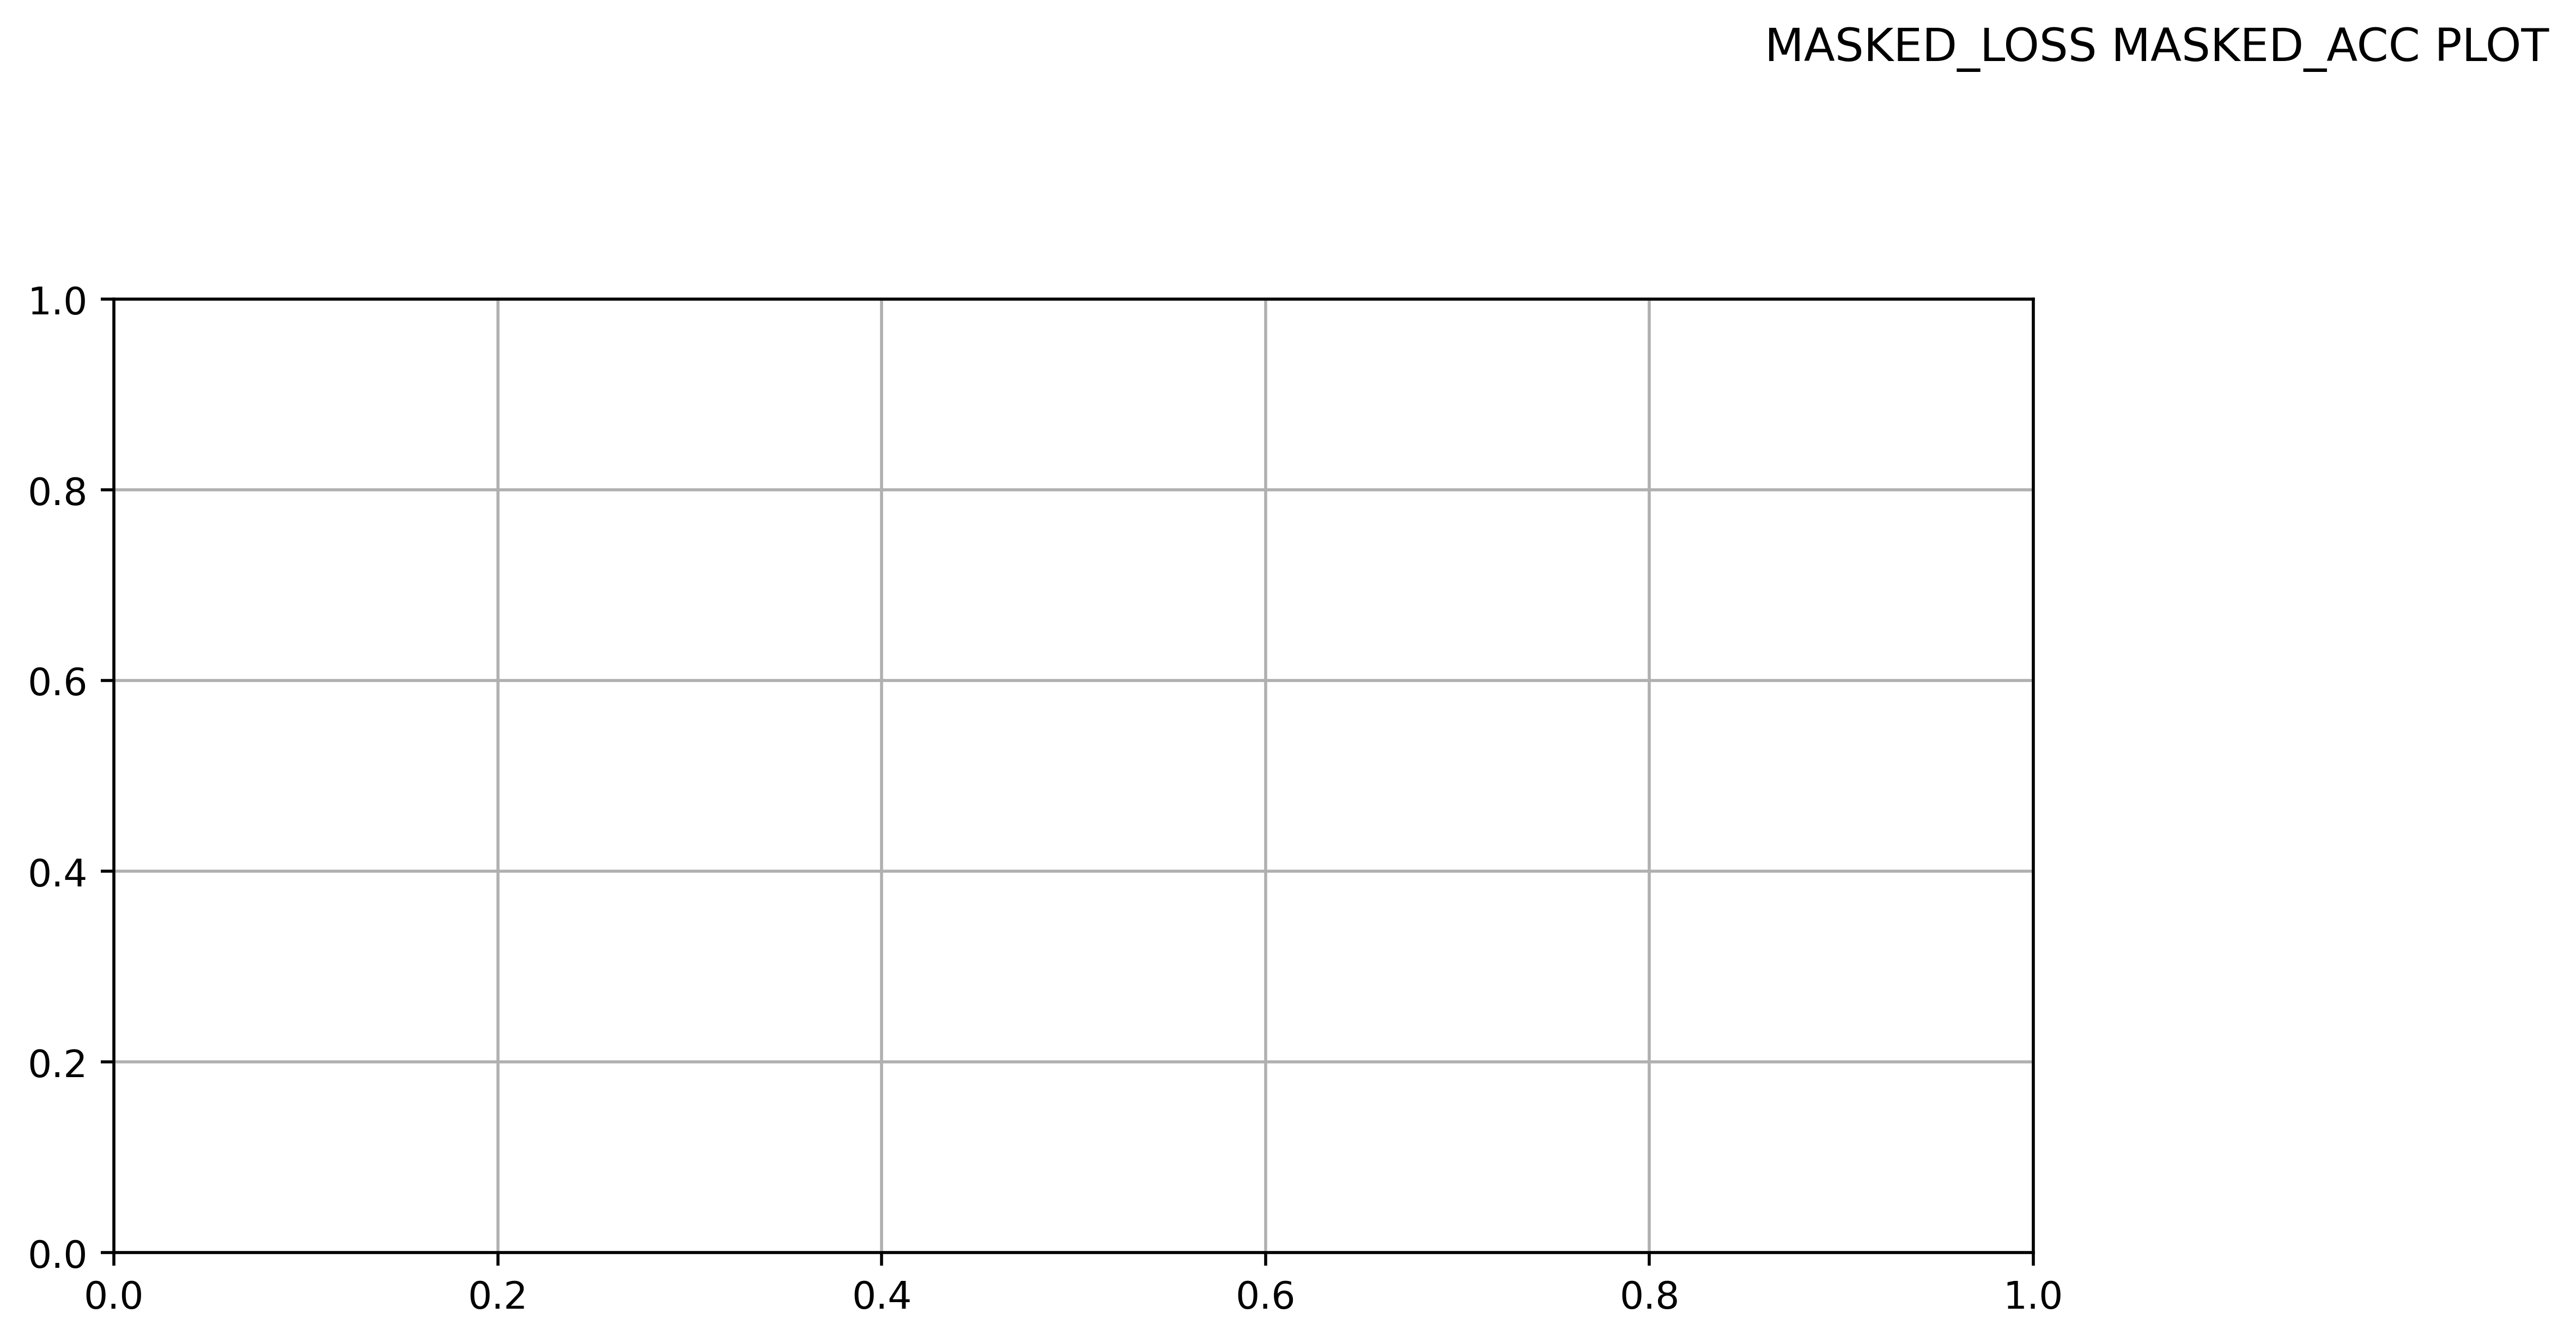

In [38]:
plot_history(history, plot = ['masked_loss','masked_acc'], split = ['train','val'], epoch= EPOCHS, figsize = (20,10), colors = ['r','b'])

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:

# model.save(f'/content/drive/MyDrive/cap-gen/{datetime.datetime.now()}-{EPOCHS}.tf')

pred = model.predict(test_data.take(1))
# print((pred.shape))

# start_token_id = word_to_id('startseq') 
# end_token_id = word_to_id('endseq') 



# aa = generate_caption(random_image_path, model, tokenizer)
# print(aa)


1/1 [==============================] - 9s 9s/step


In [55]:
pred.shape

(8, 50, 7653)

In [57]:
from preprocessing import tokens_to_text

In [58]:
tokens_to_text(pred, tokenizer)

NameError: ignored